## This is Classification Model Training for DDR dataset. This model uses Densenet-121 a pretrained model.



### STEPS for model training
##### Step 1. Define Preprocessing Function 
###### Median Filtering, CLAHE, Gamma Correction
##### Step 2. Create Custom Dataset for preprocessing (Pytorch doesn't supports Custom Preprocessing)
##### Step 3. Define Transform (with data augmentation)
##### Step 4. Create datasets and Dataloaders
##### Step 5. Load DenseNet-121 Model
##### Step 6. Define Loss, Optimizer, Scheduler
##### Step 7. Model Training
##### Step 8. Validation and Evaluation
##### Step 9. visualize 
##### Step 10. Save the model

## Dataset Descrption

### DDR dataset contains 13,673 fundus images from 147 hospitals, covering 23 provinces in China. The images are classified into 5 classes according to DR severity: none, mild, moderate, severe, and proliferative DR. There is a sixth category which indicates the images with poor quality. The dataset presented here does not include the images with poor quality (sixth category) and all images have been preprocessed to delete the black background. https://www.kaggle.com/datasets/mariaherrerot/ddrdataset

### Import Libraries

In [ ]:
# Importing necessary libraries for various operations

# OS module helps in interacting with the operating system (file and directory handling)
import os

# OpenCV library for image processing
import cv2

# NumPy for numerical operations and handling arrays
import numpy as np

# Pandas for working with structured data like CSV or Excel (DataFrames)
import pandas as pd

# PIL (Python Imaging Library) for handling images in Python
from PIL import Image

# Matplotlib for data visualization (plotting graphs and images)
from matplotlib import pyplot as plt

# Function to split dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Shutil helps with file operations like copying and moving files
import shutil 

# PyTorch main library - used for building and training deep learning models
import torch

# PyTorch neural network module - contains layers and loss functions
import torch.nn as nn

# TQDM for showing progress bars during training or data processing loops
from tqdm import tqdm

# PyTorch's optimizer module - includes optimizers like Adam, SGD, etc.
import torch.optim as optim

# Learning rate scheduler - automatically adjusts the learning rate during training
from torch.optim.lr_scheduler import StepLR

# Custom Dataset and DataLoader utilities for batch processing
from torch.utils.data import Dataset, DataLoader

# Pre-trained models and image transformation tools from torchvision
from torchvision import models, transforms


## Load and split to train_test_val DDR Dataset

In [ ]:
# Load CSV
# Load the CSV file that contains image IDs and their corresponding labels (diagnosis)
df = pd.read_csv("D:\\DR_Classification\\dataset\\DR_grading.csv") #change path to your csv file

# Add a new column 'image_path' which holds the full path to each image file
df['image_path'] = df['id_code'].apply(lambda x: os.path.join("D:\\DR_Classification\\dataset\\images", x)) #change path to your image folder

# Rename the 'diagnosis' column to 'label' to match deep learning convention (features vs label)
df['label'] = df['diagnosis']

# Create output directories for storing train and test images
output_root = "D:\\DR_Classification\\splits" #change path to your output folder
os.makedirs(os.path.join(output_root, "train"), exist_ok=True)  # Creates 'train' folder if not existing
os.makedirs(os.path.join(output_root, "test"), exist_ok=True)   # Creates 'test' folder if not existing

# Split the dataset into training and testing sets
# test_size=0.3 means 30% of the data will go to the test set
# stratify ensures each class is proportionally represented in both train and test
# random_state ensures reproducibility of the split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Define a function to copy the images to their respective folders and save split CSV files
def save_split(df_split, split_name):
    # Define the folder where the images will be saved (either train or test)
    split_folder = os.path.join(output_root, split_name)
    new_paths = []

    # Define the path for the split's CSV file (e.g., train_labels.csv)
    csv_path = os.path.join(output_root, f"{split_name}_labels.csv")
    
    # If the CSV already exists, skip processing to avoid duplication
    if os.path.exists(csv_path):
        print(f"{split_name}_labels.csv already exists. Skipping this split.")
        return

    # Loop through each row in the split DataFrame
    for _, row in df_split.iterrows():
        src = row['image_path']  # original image path
        dst = os.path.join(split_folder, os.path.basename(src))  # destination path in train/test folder

        # Copy the image if it exists
        if os.path.exists(src):
            shutil.copy(src, dst)
            new_paths.append(dst)  # store the new path for saving in CSV
        else:
            print(f"Warning: Missing image file {src}")  # error message if file not found

    # Create a copy of the split DataFrame and add the new image paths
    df_split = df_split.copy()
    df_split['new_path'] = new_paths

    # Save relevant columns into a new CSV file (id, label, new image path)
    df_split[['id_code', 'label', 'new_path']].to_csv(csv_path, index=False)
    print(f"{split_name}_labels.csv saved successfully!")

# Save the training and testing splits
save_split(train_df, "train")
save_split(test_df, "test")

# Final print to confirm everything worked
print("Splits and CSVs checked and saved successfully!")

train_labels.csv already exists. Skipping this split.
test_labels.csv already exists. Skipping this split.
Splits and CSVs checked and saved successfully!


In [ ]:
print(df['image_path'].head()) # Display the first few rows of the DataFrame to verify paths

0    D:\DR_Classification\dataset\images\2017041310...
1    D:\DR_Classification\dataset\images\2017041311...
2    D:\DR_Classification\dataset\images\2017041311...
3    D:\DR_Classification\dataset\images\2017041311...
4    D:\DR_Classification\dataset\images\2017041311...
Name: image_path, dtype: object


In [4]:
# Count samples per class in each split
print("Train class distribution:")
print(train_df['label'].value_counts())

print("\nTest class distribution:")
print(test_df['label'].value_counts())

# Count the total number of images in each split
print(f"Total: {len(df)} images")
print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train class distribution:
label
0    4386
2    3134
4     639
1     441
3     165
Name: count, dtype: int64

Test class distribution:
label
0    1880
2    1343
4     274
1     189
3      71
Name: count, dtype: int64
Total: 12522 images
Train: 8765
Test: 3757


In [ ]:
# Load the split CSVs
train_df = pd.read_csv("D:/DR_Classification/splits/train_labels.csv")
test_df = pd.read_csv("D:/DR_Classification/splits/test_labels.csv")

# Extract paths and labels
train_paths = train_df['new_path'].tolist()
train_labels = train_df['label'].tolist()

test_paths = test_df['new_path'].tolist() 
test_labels = test_df['label'].tolist() 

### Step 1. Define Preprocessing Functions

In [ ]:
# Applies a Median Filter to remove noise (especially salt-and-pepper noise)
def apply_median_filter(image):
    # cv2.medianBlur applies a median filter with a 3x3 kernel
    return cv2.medianBlur(image, 3)


# Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance local contrast
def apply_clahe(image):
    # Convert the image from RGB color space to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Split LAB into individual channels: L (lightness), A (green–red), B (blue–yellow)
    l, a, b = cv2.split(lab)
    
    # Create a CLAHE object with clipLimit=2.0 (limits contrast amplification)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    
    # Apply CLAHE to the L channel (intensity)
    cl = clahe.apply(l)
    
    # Merge the enhanced L channel with the original A and B channels
    merged = cv2.merge((cl, a, b))
    
    # Convert the image back from LAB to RGB color space
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)


# Applies Gamma Correction to adjust image brightness
def apply_gamma_correction(image, gamma=1.2):
    # Calculate the inverse of gamma
    invGamma = 1.0 / gamma

    # Create a lookup table for all pixel values (0–255)
    # Each pixel is transformed based on gamma value
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # Apply the gamma correction using the lookup table
    return cv2.LUT(image, table)


# Applies a Gaussian Blur to smooth the image and reduce noise/detail
def apply_gaussian_filter(image, kernel_size=(5, 5), sigma=1.0):
    # cv2.GaussianBlur uses a Gaussian kernel to blur the image
    # kernel_size defines the width and height of the filter
    # sigma defines how much to blur (higher = more blur)
    return cv2.GaussianBlur(image, kernel_size, sigma)


#### For the ESRGAN if applicable (Future)

In [7]:
# def apply_esrgan(image):
#     # Placeholder: You should replace with actual ESRGAN model output
#     return enhance_with_esrgan(image)

### Step 2. Create Custom Dataset

In [17]:
# Apply customary dataset
class DDRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocessing steps
        image = apply_median_filter(image)
        image = apply_clahe(image)
        image = apply_gamma_correction(image)
        
        # Apply Gaussian filter
        image = apply_gaussian_filter(image, kernel_size=(5, 5), sigma=1.0)

        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


### Step 3. Define Transforms with data augmentations

In [18]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Add vertical flip
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet pretraining normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # this is the same as training
])


### Step 4. Create Datasets and Dataloaders

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Dataset class should accept image paths and labels
train_dataset = DDRDataset(train_paths, train_labels, transform=train_transform)
test_dataset = DDRDataset(test_paths, test_labels, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Step 5. Load DenseNet-121 model

In [21]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 5)  # DDR has 5 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

d:\DR_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DR_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Step 6. Define Loss, Optimizer, Scheduler, checkpoint

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

### Step 7. Train the Model

In [23]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=15, device='cuda'):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Add tqdm progress bar
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backpropagate
                optimizer.step()  # Update weights

                running_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

                pbar.set_postfix(loss=running_train_loss / (batch_idx + 1), accuracy=correct_train / total_train * 100)
                pbar.update(1)  # Update progress bar

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train * 100

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        scheduler.step()  # Step the learning rate scheduler

# Call the function
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=15, device=device)

Epoch 1/15:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 274/274 [41:09<00:00,  9.01s/it, accuracy=68.1, loss=0.833]


Epoch 1/15
Train Loss: 0.8326 | Train Accuracy: 68.09%


Epoch 2/15: 100%|██████████| 274/274 [41:55<00:00,  9.18s/it, accuracy=73.7, loss=0.706]


Epoch 2/15
Train Loss: 0.7060 | Train Accuracy: 73.68%


Epoch 3/15: 100%|██████████| 274/274 [42:13<00:00,  9.25s/it, accuracy=75.8, loss=0.666]


Epoch 3/15
Train Loss: 0.6662 | Train Accuracy: 75.79%


Epoch 4/15: 100%|██████████| 274/274 [39:27<00:00,  8.64s/it, accuracy=76.9, loss=0.636]


Epoch 4/15
Train Loss: 0.6361 | Train Accuracy: 76.89%


Epoch 5/15: 100%|██████████| 274/274 [41:08<00:00,  9.01s/it, accuracy=77.7, loss=0.628]


Epoch 5/15
Train Loss: 0.6281 | Train Accuracy: 77.70%


Epoch 6/15: 100%|██████████| 274/274 [41:22<00:00,  9.06s/it, accuracy=80.3, loss=0.547]


Epoch 6/15
Train Loss: 0.5466 | Train Accuracy: 80.31%


Epoch 7/15: 100%|██████████| 274/274 [40:05<00:00,  8.78s/it, accuracy=81.5, loss=0.512]


Epoch 7/15
Train Loss: 0.5121 | Train Accuracy: 81.48%


Epoch 8/15: 100%|██████████| 274/274 [41:18<00:00,  9.05s/it, accuracy=82.5, loss=0.488]


Epoch 8/15
Train Loss: 0.4880 | Train Accuracy: 82.49%


Epoch 9/15: 100%|██████████| 274/274 [42:20<00:00,  9.27s/it, accuracy=82.7, loss=0.473]


Epoch 9/15
Train Loss: 0.4732 | Train Accuracy: 82.66%


Epoch 10/15: 100%|██████████| 274/274 [40:16<00:00,  8.82s/it, accuracy=83.2, loss=0.465]


Epoch 10/15
Train Loss: 0.4646 | Train Accuracy: 83.17%


Epoch 11/15: 100%|██████████| 274/274 [39:24<00:00,  8.63s/it, accuracy=85, loss=0.433]  


Epoch 11/15
Train Loss: 0.4328 | Train Accuracy: 85.01%


Epoch 12/15: 100%|██████████| 274/274 [39:36<00:00,  8.67s/it, accuracy=84.3, loss=0.438]


Epoch 12/15
Train Loss: 0.4381 | Train Accuracy: 84.26%


Epoch 13/15: 100%|██████████| 274/274 [38:42<00:00,  8.48s/it, accuracy=84.9, loss=0.427]


Epoch 13/15
Train Loss: 0.4268 | Train Accuracy: 84.93%


Epoch 14/15: 100%|██████████| 274/274 [39:57<00:00,  8.75s/it, accuracy=84.5, loss=0.429]


Epoch 14/15
Train Loss: 0.4288 | Train Accuracy: 84.50%


Epoch 15/15: 100%|██████████| 274/274 [43:25<00:00,  9.51s/it, accuracy=84.6, loss=0.43] 

Epoch 15/15
Train Loss: 0.4299 | Train Accuracy: 84.61%


### Step 8. Validate and Evaluate the Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# -------------------------------
# 1. Load test images
# -------------------------------
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Use the custom DDRDataset class
test_dataset = DDRDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------------
# 2. Load the model architecture
# -------------------------------
model = models.densenet121(pretrained=False)  # Use DenseNet-121 architecture
model.classifier = nn.Linear(model.classifier.in_features, 5)  # Adjust for 5 classes in DDR dataset 
model.load_state_dict(torch.load(r"D:\DR_Classification\Model\Pretrained_Densenet-121.pth", map_location=torch.device('cpu'))) # Load the trained model weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# 3. Define loss function
# -------------------------------
criterion = nn.CrossEntropyLoss()

# -------------------------------
# 4. Evaluation function
# -------------------------------
def evaluation_test_model(model, test_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Evaluating on Test Set") as pbar:
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.update(1)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total * 100
    return val_loss, val_acc

# -------------------------------
# 5. Evaluate
# -------------------------------
val_loss, val_acc = evaluation_test_model(model, test_loader, criterion, device)
print(f"\n✅ Test Loss: {val_loss:.4f} | Test Accuracy: {val_acc:.2f}%")


d:\DR_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DR_Classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating on Test Set: 100%|██████████| 118/118 [07:28<00:00,  3.80s/it]


✅ Test Loss: 0.4824 | Test Accuracy: 83.20%


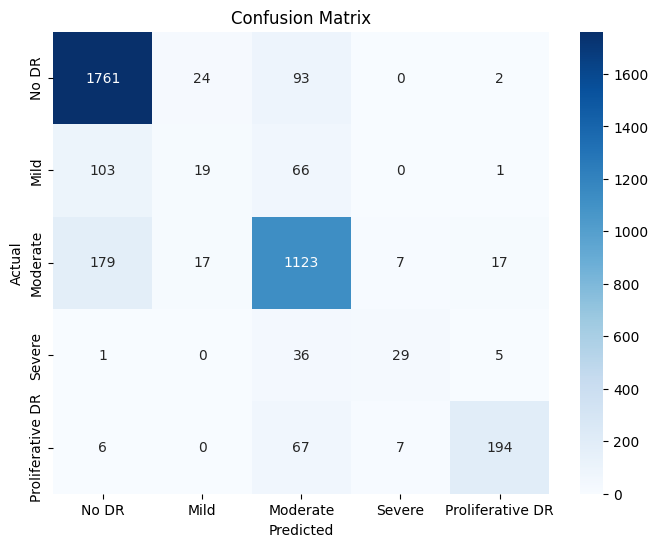


📊 Classification Report:
                   precision    recall  f1-score   support

           No DR       0.86      0.94      0.90      1880
            Mild       0.32      0.10      0.15       189
        Moderate       0.81      0.84      0.82      1343
          Severe       0.67      0.41      0.51        71
Proliferative DR       0.89      0.71      0.79       274

        accuracy                           0.83      3757
       macro avg       0.71      0.60      0.63      3757
    weighted avg       0.81      0.83      0.82      3757



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# 6. Get predictions for metrics
# -------------------------------
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# 7. Confusion Matrix
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -------------------------------
# 8. Classification Report
# -------------------------------
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\n📊 Classification Report:\n", report)


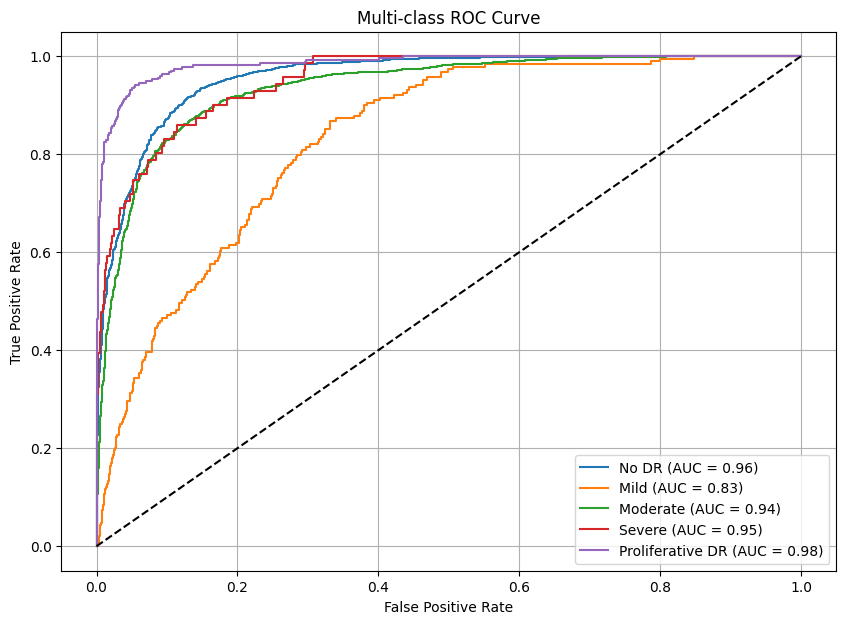

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import torch

# Number of classes for Diabetic Retinopathy (DR) classification
n_classes = 5  

# Convert class labels to one-hot encoded format (needed for multi-class ROC)
# Example: label 2 becomes [0, 0, 1, 0, 0]
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])

# Will hold predicted probabilities for each class
y_scores = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation for faster inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        
        # Forward pass through the model
        outputs = model(inputs)
        
        # Apply softmax to get class probabilities
        probs = torch.softmax(outputs, dim=1)
        
        # Append the probabilities to y_scores list
        y_scores.extend(probs.cpu().numpy())

# Convert the list of predictions to a NumPy array
y_scores = np.array(y_scores)

# Initialize dictionaries to store False Positive Rate (FPR), True Positive Rate (TPR), and AUC
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    # Calculate FPR and TPR for class `i`
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    
    # Calculate Area Under Curve (AUC) for class `i`
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--')

# Set plot title and axis labels
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add legend and grid
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


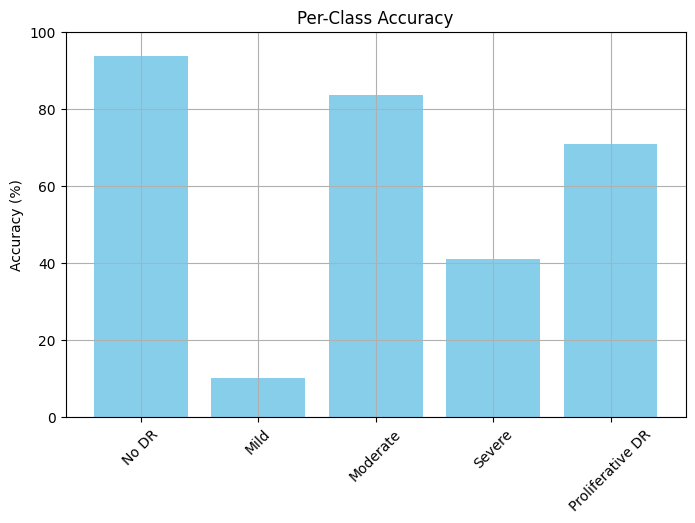

In [ ]:
# Import Counter from collections to count occurrences per class
from collections import Counter

# Dictionary to track how many predictions were correct per class
correct_per_class = Counter()

# Dictionary to track total number of samples per class
total_per_class = Counter()

# Disable gradient calculation for inference (saves memory and computation)
with torch.no_grad():
    # Loop over the test dataset
    for inputs, labels in test_loader:
        # Move input tensors to the same device as the model (CPU or GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass: get model predictions
        outputs = model(inputs)

        # Get the index of the class with the highest score for each sample
        _, predicted = torch.max(outputs, 1)

        # Compare predictions with true labels, update counters
        for label, prediction in zip(labels, predicted):
            total_per_class[label.item()] += 1  # increment total count for true class
            if label == prediction:
                correct_per_class[label.item()] += 1  # increment correct count if prediction is correct

# Compute per-class accuracy: (correct / total) * 100 for each class
# class_names[i] is used to label each class properly
class_acc = {
    class_names[i]: (correct_per_class[i] / total_per_class[i]) * 100
    for i in range(n_classes)
}

# Visualization: Bar plot of per-class accuracy
plt.figure(figsize=(8, 5))
plt.bar(class_acc.keys(), class_acc.values(), color='skyblue')  # bar plot with class labels and their accuracy
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)  # Rotate class names on x-axis for better readability
plt.ylim(0, 100)  # Set y-axis range from 0 to 100 percent
plt.grid(True)
plt.show()



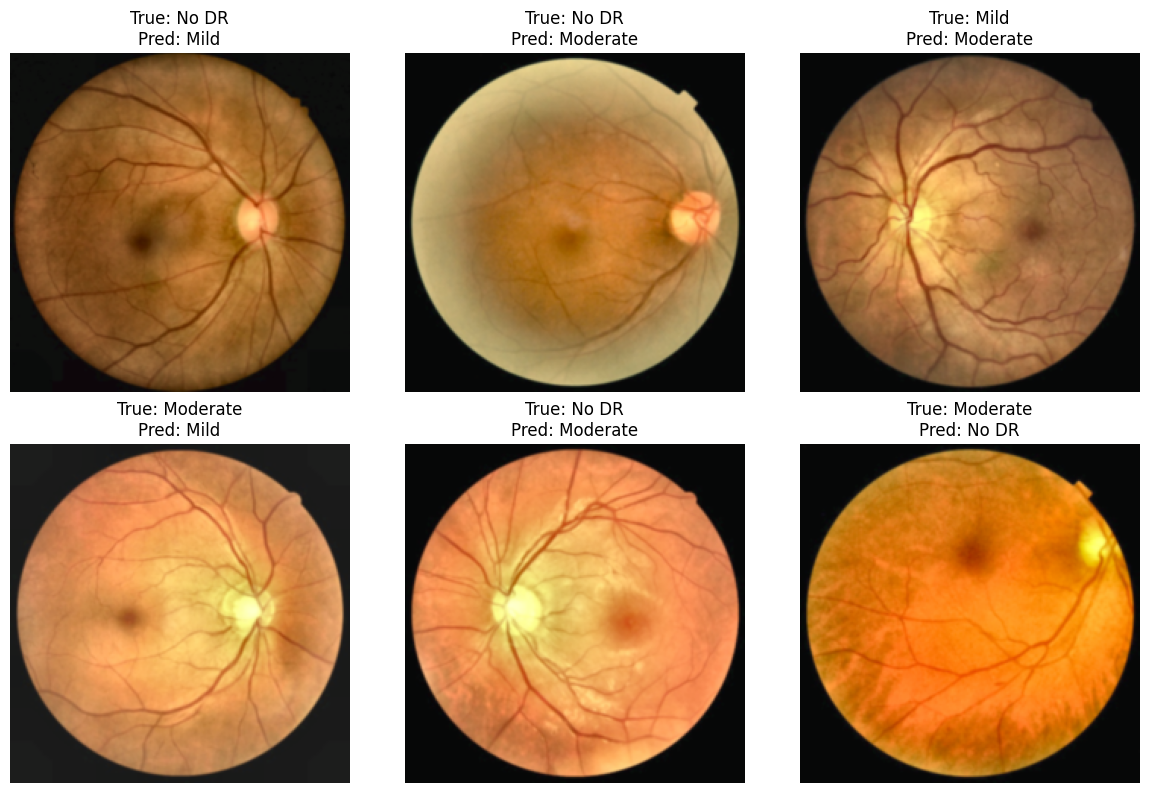

In [ ]:
# Function to visualize misclassified images from the test set
def show_misclassified(model, test_loader, class_names, device='cpu', max_images=6):
    # Set model to evaluation mode (turns off dropout, batchnorm updates)
    model.eval()
    
    # List to store misclassified images and their labels
    misclassified = []

    # Disable gradient computation for faster inference
    with torch.no_grad():
        # Iterate through the test set
        for inputs, labels in test_loader:
            # Move data to device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions from the model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Check for misclassified samples
            for img, true_label, pred_label in zip(inputs, labels, preds):
                if true_label != pred_label:
                    # Save the misclassified image and its true/predicted labels
                    misclassified.append((img.cpu(), true_label.item(), pred_label.item()))
                
                # Stop once we’ve collected enough misclassified samples
                if len(misclassified) >= max_images:
                    break
            if len(misclassified) >= max_images:
                break

    # Plot the misclassified images
    plt.figure(figsize=(12, 8))
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        plt.subplot(2, 3, i+1)  # Plot up to 6 images in a 2x3 grid
        
        # Convert tensor image to NumPy format and undo normalization
        img = img.permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Undo normalization (ImageNet stats)
        img = np.clip(img, 0, 1)  # Make sure pixel values are within [0, 1]

        # Display the image
        plt.imshow(img)
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        plt.axis('off')  # Hide axis ticks
    
    plt.tight_layout()
    plt.show()

# Call the function to show misclassified samples
show_misclassified(model, test_loader, class_names, device=device)


### Step 9. Visualize predictions

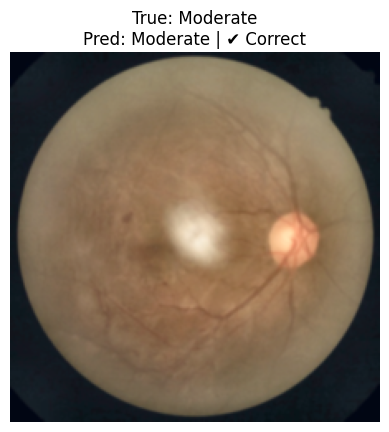

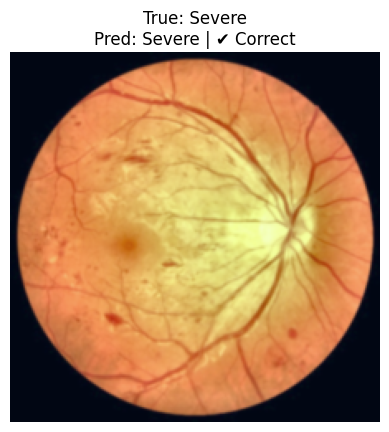

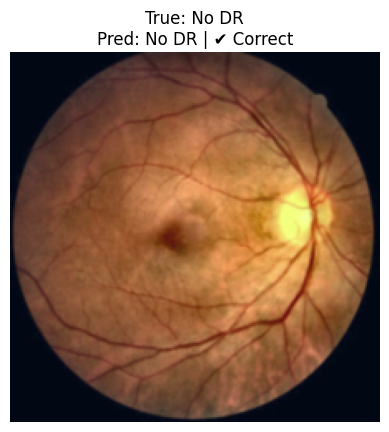

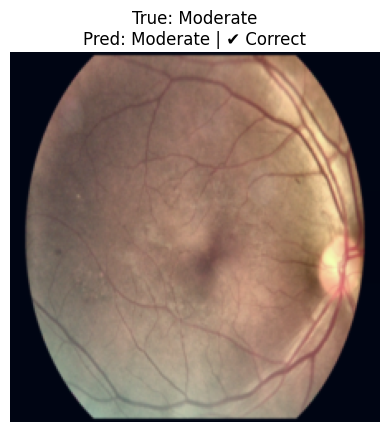

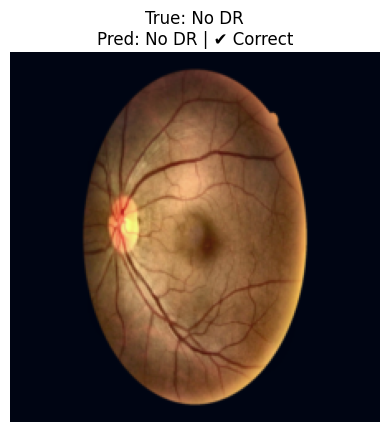

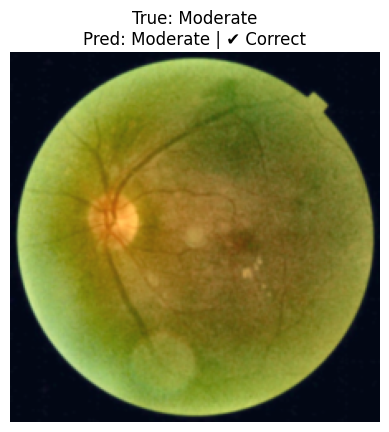

d:\DR_Classification\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


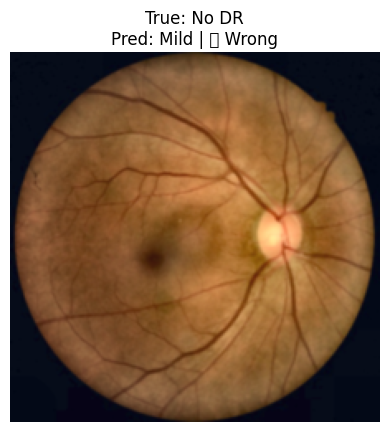

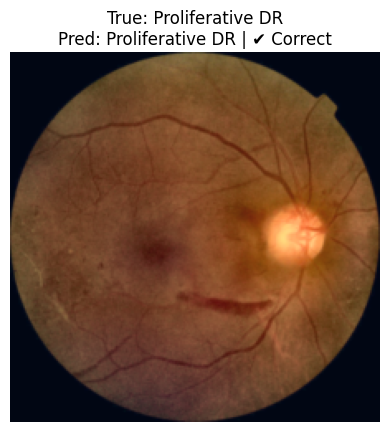


✅ Total Correct: 7/8 — Accuracy: 87.50%


In [ ]:
# Function to visualize a few predictions from the model
def visualize_predictions(model, dataloader, class_names, device='cuda', num_images=6):
    model.eval()  # Set the model to evaluation mode (no dropout, no gradients)
    images_shown = 0  # Counter for how many images we've displayed
    correct_preds = 0  # Counter for how many predictions were correct

    with torch.no_grad():  # No need to calculate gradients during inference
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Move input batch to GPU/CPU
            labels = labels.to(device)

            outputs = model(inputs)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get predicted class indices

            # Move back to CPU for visualization
            inputs = inputs.cpu()
            labels = labels.cpu()
            preds = preds.cpu()

            # Loop through the batch and visualize one image at a time
            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    # Print final summary and return
                    print(f"\n✅ Total Correct: {correct_preds}/{num_images} — Accuracy: {(correct_preds / num_images) * 100:.2f}%")
                    return

                # Convert tensor image to NumPy array and normalize values for visualization
                img = inputs[i].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
                img = (img - img.min()) / (img.max() - img.min())  # Scale pixel values to [0, 1]

                # Determine if the prediction is correct
                is_correct = preds[i] == labels[i]
                correctness = "✔️ Correct" if is_correct else "❌ Wrong"
                if is_correct:
                    correct_preds += 1

                # Display the image with its true and predicted labels
                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]} | {correctness}")
                plt.axis("off")
                plt.show()

                images_shown += 1  # Increment the counter

    # Final accuracy summary if loop finishes naturally
    print(f"\n✅ Total Correct: {correct_preds}/{num_images} — Accuracy: {(correct_preds / num_images) * 100:.2f}%")

# Example usage
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
visualize_predictions(model, test_loader, class_names, device=device, num_images=8)


### Step 10. Save The Model

In [32]:
torch.save(model.state_dict(), "Pretrained_Densenet-121.pth")
print("✅ Final model saved as 'Pretrained Densenet 121.pth'")

✅ Final model saved as 'Pretrained Densenet 121.pth'


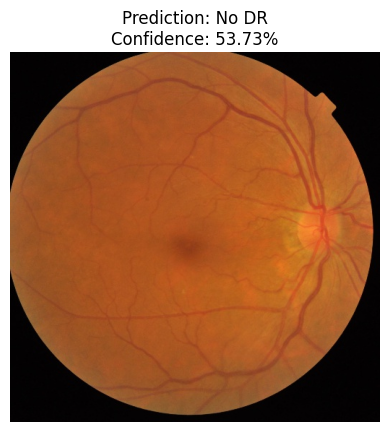

Predicted Class: No DR
Confidence: 53.73%


In [ ]:
def predict_image(model, image_path, class_names, device='cuda'):
    # Load the image
    img = Image.open(image_path).convert("RGB")
    
    # Define the transformations (same as during training)
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the image
        transforms.CenterCrop(224),  # Crop the image
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
    ])
    
    # Apply transformations
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Set model to evaluation mode
    model.eval()
    
    # Disable gradient computation for prediction
    with torch.no_grad():
        # Forward pass
        outputs = model(img_tensor)
        
        # Get the predicted class and confidence score (probability)
        _, preds = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)  # Get the softmax probabilities
        confidence_percentage = 100 * confidence[0][preds.item()]  # Confidence for the predicted class

    # Get the class name
    predicted_class = class_names[preds.item()]
    
    # Plot the image and show prediction with confidence
    img = np.array(img)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_percentage:.2f}%")
    plt.axis("off")
    plt.show()
    
    return predicted_class, confidence_percentage

# Example usage:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']  # Modify as per your dataset
image_path = r'D:\DR_Classification\splits\train\007-0025-000.jpg'  # Replace with your image path
predicted_class, confidence_percentage = predict_image(model, image_path, class_names, device='cpu')

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence_percentage:.2f}%")